In [1]:
import os, sys
import pandas as pd 
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from datetime import datetime
import datetime as dt
import featexp
import sklearn
from scipy.stats import *
from math import sqrt
os.chdir("/Users/supark/Downloads")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# data cleaning 

In [2]:
data = pd.read_csv('concha_data.csv')

/Users/supark/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data.head()

,test_date,nid,L500k,L1k,L2k,L3k,L4k,L6k,L8k,R500k,R1k,R2k,R3k,R4k,R6k,R8k,gender,naics,age_group,region,NAICS_descr
0,08-FEB-2005,1,10,5,5,15,10,5,25,20,20,15,10,10,25,45,M,331512,4.0,MA,Steel Investment Foundries
1,17-MAR-2009,1,15,10,5,15,5,10,25,15,20,20,15,10,35,55,M,331512,5.0,MA,Steel Investment Foundries
2,08-FEB-2005,2,5,10,20,20,15,20,0,5,0,5,10,10,15,15,M,331512,2.0,MA,Steel Investment Foundries
3,29-FEB-2008,2,15,5,15,20,20,15,15,10,0,10,15,30,20,15,M,331512,3.0,MA,Steel Investment Foundries
4,08-FEB-2006,3,25,20,15,20,35,25,15,20,20,10,15,40,30,30,M,331512,3.0,MA,Steel Investment Foundries


In [4]:
data.describe()

,nid,naics,age_group
count,2.944670e+06,2.944670e+06,2.927950e+06
mean,2.079236e+06,3.746427e+05,2.812442e+00
std,1.225354e+06,1.327616e+05,1.185800e+00
min,1.000000e+00,2.300000e+01,1.000000e+00
25%,5.805815e+05,3.219110e+05,2.000000e+00
50%,2.504568e+06,3.323120e+05,3.000000e+00
75%,3.080831e+06,4.222100e+05,4.000000e+00
max,3.659841e+06,9.281100e+05,5.000000e+00


In [5]:
# set other parameters as index 
data = data.set_index(['test_date','nid', 'gender', 'naics', 'age_group', 'region', 'NAICS_descr'])

# divide left and right to merge together 
left = data.iloc[:,0:7]
right = data.iloc[:,7:14]

left = left.reset_index()
right = right.reset_index()

# create a new column called "left" to distinguish left from right if needed
left['left'] = 1  
right['left'] = 0 

# rename columns to remove L/R
left = left.rename(columns={'L500k':'500k', 'L1k': '1k', 'L2k': '2k', 'L3k': '3k', 'L4k': '4k', 'L6k':'6k', 'L8k':'8k'})
right = right.rename(columns={'R500k':'500k', 'R1k': '1k', 'R2k': '2k', 'R3k': '3k', 'R4k': '4k', 'R6k':'6k', 'R8k':'8k'})

# concat
merge = pd.concat([left, right])
merge.head()

,test_date,nid,gender,naics,age_group,region,NAICS_descr,500k,1k,2k,3k,4k,6k,8k,left
0,08-FEB-2005,1,M,331512,4.0,MA,Steel Investment Foundries,10,5,5,15,10,5,25,1
1,17-MAR-2009,1,M,331512,5.0,MA,Steel Investment Foundries,15,10,5,15,5,10,25,1
2,08-FEB-2005,2,M,331512,2.0,MA,Steel Investment Foundries,5,10,20,20,15,20,0,1
3,29-FEB-2008,2,M,331512,3.0,MA,Steel Investment Foundries,15,5,15,20,20,15,15,1
4,08-FEB-2006,3,M,331512,3.0,MA,Steel Investment Foundries,25,20,15,20,35,25,15,1


In [6]:
# remove rows with at least one na (data set is already large)
merge.isna().sum() 
merge = merge.dropna() 



In [7]:
# exploratory data analysis 

# there are audiogram cells that have "**" instead of actual numbers written. remove those.
merge = merge.set_index(['test_date','nid', 'naics', 'NAICS_descr', 'gender', 'age_group', 'region'])  
merge_clean = merge.apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna() 
merge_clean.info() 


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4174125 entries, ('08-FEB-2005', 1, 331512, 'Steel Investment Foundries', 'M', 4.0, 'MA') to ('14-APR-2008', 3659841, 327121, 'Brick and Structural Clay Tile Manufacturing', 'M', 5.0, 'SO')
Data columns (total 8 columns):
 #   Column  Dtype  
---  ------  -----  
 0   500k    float64
 1   1k      float64
 2   2k      float64
 3   3k      float64
 4   4k      float64
 5   6k      float64
 6   8k      float64
 7   left    int64  
dtypes: float64(7), int64(1)
memory usage: 384.8+ MB


In [10]:
# create dummy variables for gender, region, and age group to see if they have any correlation with the audiogram columns 
merge_clean = merge_clean.reset_index()
gender_dummies = pd.get_dummies(merge_clean.gender)
region_dummies = pd.get_dummies(merge_clean.region)

merge1 = pd.concat([merge_clean, gender_dummies], axis=1)
merge2 = pd.concat([merge1, region_dummies], axis=1)

age_dummies = pd.get_dummies(merge2.age_group)
merge3 = pd.concat([merge2, age_dummies], axis=1) 

merge3 = merge3.drop(columns=['age_group', 'gender', 'region']) 
merge3.head()
merge3.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4174125 entries, 0 to 4174124
Data columns (total 26 columns):
 #   Column       Dtype  
---  ------       -----  
 0   index        int64  
 1   test_date    object 
 2   nid          int64  
 3   naics        int64  
 4   NAICS_descr  object 
 5   500k         float64
 6   1k           float64
 7   2k           float64
 8   3k           float64
 9   4k           float64
 10  6k           float64
 11  8k           float64
 12  left         int64  
 13  F            uint8  
 14  M            uint8  
 15  MA           uint8  
 16  MW           uint8  
 17  NE           uint8  
 18  SO           uint8  
 19  SW           uint8  
 20  WE           uint8  
 21  1.0          uint8  
 22  2.0          uint8  
 23  3.0          uint8  
 24  4.0          uint8  
 25  5.0          uint8  
dtypes: float64(7), int64(4), object(2), uint8(13)
memory usage: 465.7+ MB


In [11]:
merge3.set_index(['test_date','nid', 'naics', 'NAICS_descr'], inplace=True)  

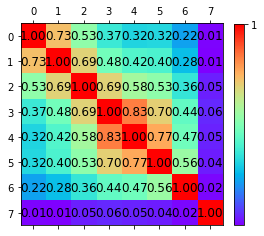

In [13]:
# let's check for correlation amongst the audiogram variables and left/right. 
# between the audiogram variables and other demographic variables 
cov_data = np.corrcoef(merge3[['500k', '1k', '2k', '3k', '4k', '6k', '8k', 'left']].T)

img = plt.matshow(cov_data, cmap=plt.cm.rainbow)
plt.colorbar(img, ticks = [-1, 0, 1], fraction=0.045)

for x in range(cov_data.shape[0]):
    for y in range(cov_data.shape[1]):
        plt.text(x, y, "%0.2f" % cov_data[x,y], size=12, color='black', ha="center", va="center")
        
plt.show()

In [ ]:
# correlation between (3k and 4k), (4k and 6k), (3k and 6k), (500k and 1k), (1k and 2k), and (2k and 3k).  
# left/right seems completely independent from the frequency performance.  

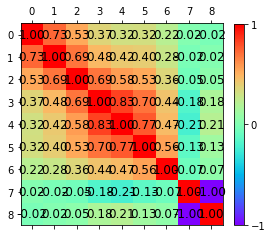

In [14]:
# check with gender 

cov_data = np.corrcoef(merge3[['500k', '1k', '2k', '3k', '4k', '6k', '8k', 'F', 'M']].T) 

img = plt.matshow(cov_data, cmap=plt.cm.rainbow)
plt.colorbar(img, ticks = [-1, 0, 1], fraction=0.045)

for x in range(cov_data.shape[0]):
    for y in range(cov_data.shape[1]):
        plt.text(x, y, "%0.2f" % cov_data[x,y], size=12, color='black', ha="center", va="center")
        
plt.show()

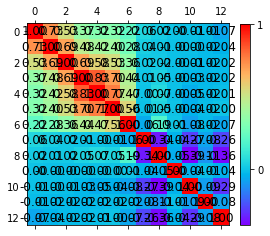

In [17]:
# check with region 

cov_data = np.corrcoef(merge3[['500k', '1k', '2k', '3k', '4k', '6k', '8k', 'MA', 'MW', 'NE', 'SO', 'SW', 'WE']].T)

img = plt.matshow(cov_data, cmap=plt.cm.rainbow)
plt.colorbar(img, ticks = [-1, 0, 1], fraction=0.045)

for x in range(cov_data.shape[0]):
    for y in range(cov_data.shape[1]):
        plt.text(x, y, "%0.2f" % cov_data[x,y], size=12, color='black', ha="center", va="center")
        
plt.show() 

In [ ]:
# gender and region also seems to have very little corrleation with the audiograms. 

In [19]:
merge3 = merge3.drop(columns=['index'])

In [21]:
merge4 = merge3.drop(merge3.iloc[:, 8:21], axis = 1)

In [23]:
merge4 = merge4.reset_index()

In [29]:
merge4.head()

,test_date,nid,naics,NAICS_descr,500k,1k,2k,3k,4k,6k,8k,left
0,08-FEB-2005,1,331512,Steel Investment Foundries,10.0,5.0,5.0,15.0,10.0,5.0,25.0,1
1,17-MAR-2009,1,331512,Steel Investment Foundries,15.0,10.0,5.0,15.0,5.0,10.0,25.0,1
2,08-FEB-2005,2,331512,Steel Investment Foundries,5.0,10.0,20.0,20.0,15.0,20.0,0.0,1
3,29-FEB-2008,2,331512,Steel Investment Foundries,15.0,5.0,15.0,20.0,20.0,15.0,15.0,1
4,08-FEB-2006,3,331512,Steel Investment Foundries,25.0,20.0,15.0,20.0,35.0,25.0,15.0,1


In [ ]:
merge4.to_csv('0405_concha_cleaned.csv', index=False)

In [2]:
data = pd.read_csv('0405_concha_cleaned.csv')

In [3]:
len(data)

2715212

In [4]:
data.head(20)

,test_date,nid,naics,NAICS_descr,500k,1k,2k,3k,4k,6k,8k,left
0,08-FEB-2005,1,331512,Steel Investment Foundries,10.0,5.0,5.0,15.0,10.0,5.0,25.0,1
1,17-MAR-2009,1,331512,Steel Investment Foundries,15.0,10.0,5.0,15.0,5.0,10.0,25.0,1
2,08-FEB-2005,2,331512,Steel Investment Foundries,5.0,10.0,20.0,20.0,15.0,20.0,0.0,1
3,29-FEB-2008,2,331512,Steel Investment Foundries,15.0,5.0,15.0,20.0,20.0,15.0,15.0,1
4,08-FEB-2006,3,331512,Steel Investment Foundries,25.0,20.0,15.0,20.0,35.0,25.0,15.0,1
5,08-FEB-2005,4,331512,Steel Investment Foundries,15.0,20.0,30.0,30.0,40.0,60.0,45.0,1
6,12-FEB-2007,4,331512,Steel Investment Foundries,10.0,15.0,35.0,25.0,25.0,70.0,50.0,1
7,17-MAR-2010,5,331512,Steel Investment Foundries,25.0,25.0,35.0,60.0,80.0,90.0,85.0,1
8,08-FEB-2005,6,331512,Steel Investment Foundries,10.0,10.0,10.0,40.0,45.0,35.0,0.0,1
9,17-MAR-2010,6,331512,Steel Investment Foundries,10.0,5.0,10.0,45.0,45.0,35.0,20.0,1


In [5]:
data.set_index(['test_date', 'nid', 'naics', 'NAICS_descr', 'left'], inplace=True)

In [6]:
from sklearn import preprocessing

# standardize the data attributes
data = pd.DataFrame(preprocessing.scale(data), columns = data.columns, index = data.index)

In [24]:
data.head()

,,,,,500k,1k,2k,3k,4k,6k,8k
test_date,nid,naics,NAICS_descr,left,,,,,,,
08-FEB-2005,1,331512,Steel Investment Foundries,1,0.033757,-0.459793,-0.512192,-0.044149,-0.555886,-0.974748,0.082993
17-MAR-2009,1,331512,Steel Investment Foundries,1,0.730560,0.173518,-0.512192,-0.044149,-0.826180,-0.702688,0.082993
08-FEB-2005,2,331512,Steel Investment Foundries,1,-0.663046,0.173518,0.814070,0.265428,-0.285592,-0.158566,-0.958729
29-FEB-2008,2,331512,Steel Investment Foundries,1,0.730560,-0.459793,0.371983,0.265428,-0.015298,-0.430627,-0.333696
08-FEB-2006,3,331512,Steel Investment Foundries,1,2.124167,1.440138,0.371983,0.265428,0.795584,0.113495,-0.333696


In [25]:
from sklearn.model_selection import train_test_split

# Separate features and targets
X = data[['2k', '4k', '6k']].to_numpy()
y = data[['500k', '1k', '3k', '8k']].to_numpy()

# split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)


# neural network using Keras

In [26]:
# Load dependencies
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
import numpy as np

In [27]:
# Set the input shape
input_shape = (3,)
print(f'Feature shape: {input_shape}')

# Create the model
model = Sequential()
model.add(Dense(16, input_shape=input_shape, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='linear'))

# Configure the model and start training
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_squared_error'])

# fit the model
# 10 each to save time. 100 epochs is recommended  
history = model.fit(X_train, y_train, epochs=10, batch_size=10, verbose=1)

Feature shape: (3,)
Epoch 1/10
1819192/1819192 [==============================] - 281s 154us/sample - loss: 0.4894 - mean_squared_error: 0.5324
Epoch 2/10
1819192/1819192 [==============================] - 267s 147us/sample - loss: 0.4849 - mean_squared_error: 0.5307
Epoch 3/10
1819192/1819192 [==============================] - 535s 294us/sample - loss: 0.4839 - mean_squared_error: 0.5314
Epoch 4/10
1819192/1819192 [==============================] - 332s 183us/sample - loss: 0.4835 - mean_squared_error: 0.5304
Epoch 5/10
1819192/1819192 [==============================] - 308s 169us/sample - loss: 0.4829 - mean_squared_error: 0.5284
Epoch 6/10
1819192/1819192 [==============================] - 306s 168us/sample - loss: 0.4827 - mean_squared_error: 0.5281
Epoch 7/10
1819192/1819192 [==============================] - 316s 174us/sample - loss: 0.4827 - mean_squared_error: 0.5279
Epoch 8/10
1819192/1819192 [==============================] - 300s 165us/sample - loss: 0.4826 - mean_squared_er

In [44]:
# evaluate the model
error = model.evaluate(X_test, y_test, verbose=1)

896020/896020 [==============================] - 19s 21us/sample - loss: 0.4824 - mean_squared_error: 0.5275


In [45]:
print(error)

[0.4823617661553556, 0.52753955]


In [46]:
print(history.history)

{'loss': [0.4894159382913378, 0.48491687005231987, 0.4838604515837622, 0.48350989237371095, 0.4829225744522054, 0.48271109147457597, 0.48267913626179354, 0.48263335074100006, 0.4826591178288185, 0.4826298331792737], 'mean_squared_error': [0.53235507, 0.5307133, 0.53143156, 0.53042644, 0.52839553, 0.52807796, 0.5279122, 0.52811134, 0.52823657, 0.5281957]}


dict_keys(['loss', 'mean_squared_error'])


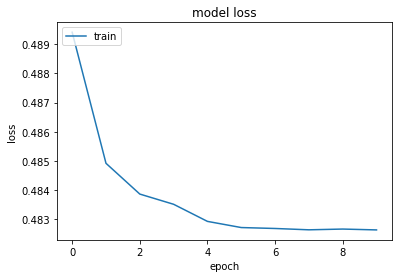

In [47]:
print(history.history.keys())

# "Loss"
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

dict_keys(['loss', 'mean_squared_error'])


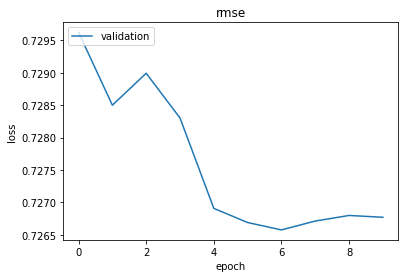

In [48]:
print(history.history.keys())

# "Loss"
plt.plot(np.sqrt(history.history['mean_squared_error']))
plt.title('rmse')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['validation'], loc='upper left')
plt.show()

# instability due to epochs only being 10. both training and validation losses decrease exponentially as epochs increase.


In [28]:
nn = model

In [17]:
# randomized search to tune hyperparameters

In [18]:
from sklearn.model_selection import * 

In [32]:
from keras.wrappers.scikit_learn import KerasRegressor

def create_model():
# create model
    model = Sequential()
    model.add(Dense(16, input_shape=input_shape, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='linear'))
# Compile model
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_squared_error'])
    return model


In [33]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [35]:
# create model
nn_keras = KerasRegressor(build_fn=create_model, verbose=0)

In [ ]:
# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
rd = RandomizedSearchCV(nn_keras, param_distributions=param_grid, n_jobs=1, cv=5, scoring='neg_mean_absolute_error', verbose=1)
rd_result = rd.fit(X_train, y_train)



In [ ]:
# summarize results
print("Best: %f using %s" % (rd_result.best_score_, rd_result.best_params_))
means = rd_result.cv_results_['mean_test_score']
stds = rd_result.cv_results_['std_test_score']
params = rd_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# simpler models (linear regression & decision tree)

In [116]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn import linear_model


In [117]:
# linear regression for multioutput regression
lin = linear_model.LinearRegression()
lin.fit(X_train, y_train)

LinearRegression()

In [118]:
lin.score(X_test,y_test)

0.4760638532086828

In [119]:
mse = mean_squared_error(y_train, lin.predict(X_train))
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train, lin.predict(X_train))

In [120]:
print(mae)

0.5083769933832


In [121]:
print(mse)

0.5239207323187953


In [122]:
print(rmse)

0.7238236886969059


In [8]:
# decision tree for multioutput regression
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor

# define model
dt = DecisionTreeRegressor()
# fit model
dt.fit(X_train, y_train)

DecisionTreeRegressor()

In [126]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

# define the evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores_ab = cross_val_score(dt, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
n_scores_sq = cross_val_score(dt, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)


In [127]:
from statistics import *

In [128]:
# force the scores to be positive
n_scores_ab = abs(n_scores_ab)
n_scores_sq = abs(n_scores_sq)

# summarize performance
print('MAE: %.3f (%.3f)' % (mean(n_scores_ab), np.std(n_scores_ab)))
print('MSE: %.3f (%.3f)' % (mean(n_scores_sq), np.std(n_scores_sq)))

MAE: 0.499 (0.001)
MSE: 0.509 (0.002)


In [129]:
# randomized search to tune hyperparameters. less expensive than grid search

from scipy.stats import randint as sp_randint

param_dist = {'max_depth': sp_randint(2,16),
              'min_samples_split': sp_randint(2,16)}

n_iter_search = 20
clfrs_mae = RandomizedSearchCV(dt, 
                                   param_distributions=param_dist,
                                   scoring='neg_mean_absolute_error',
                                   cv=5 , n_jobs=1, verbose=1,
                                   n_iter=n_iter_search)
clfrs_mae.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_iter=20, n_jobs=1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fae1e66ad50>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fae1e66a750>},
                   scoring='neg_mean_absolute_error', verbose=1)

In [130]:
clfrs_mae.cv_results_
    
print(clfrs_mae.best_params_)
print(clfrs_mae.best_score_)


{'max_depth': 13, 'min_samples_split': 5}
-0.49921793951445326


In [131]:
# randomized search: less expensive 

from scipy.stats import randint as sp_randint

param_dist = {'max_depth': sp_randint(2,16),
              'min_samples_split': sp_randint(2,16)}

n_iter_search = 20
clfrs_mse = RandomizedSearchCV(dt, 
                                   param_distributions=param_dist,
                                   scoring='neg_mean_squared_error',
                                   cv=5 , n_jobs=1, verbose=1,
                                   n_iter=n_iter_search)
clfrs_mse.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_iter=20, n_jobs=1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fae1e66a390>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fae1e66ab90>},
                   scoring='neg_mean_squared_error', verbose=1)

In [132]:
clfrs_mse.cv_results_
    
print(clfrs_mse.best_params_)
print(clfrs_mse.best_score_)


{'max_depth': 11, 'min_samples_split': 7}
-0.5067143877263265


In [ ]:
# the mae and rmse values for the three models are: (0.4828, 0.5325) for neural network, (0.508, 0.723) for linear regression, and (0.49, 0.50) for decision tree. 
# while the decision tree outperformed nn in rmse, given that our target variables are highly correlated, I decided to use nn, which is one model that predicts a vector instead of using separate models for each target variable. 


# simple interface

In [9]:
# taking multiple inputs at a time
# and type casting using list() function
#x = list(map(float, input("Enter 2k, 4k, and 6k values (separate them with commas): ").split(",")))
#print("500k, 1k, 3k, and 8k values: ", x)

twok = float(input('Enter 2k threshold value: '))
fourk = float(input('Enter 4k threshold value: '))
sixk = float(input('Enter 6k threshold value: '))
x_test = [[twok, fourk, sixk]]
print("500k, 1k, 3k, and 8k values: ", dt.predict(x_test))

Enter 2k threshold value: 0
Enter 4k threshold value: 1
Enter 6k threshold value: 0
500k, 1k, 3k, and 8k values:  [[0.06004192 0.04189022 0.58118715 0.00264491]]


# API using AWS

In [37]:
model.save('concha_nn')

In [38]:
model

In [8]:
from tensorflow import keras
nn = keras.models.load_model('concha_nn_downloads')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
